INITIALIZE

In [3]:
# Initialise Notebook
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont, ExifTags, ImageColor, ImageFilter
import time
import os
import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import urllib.request

In [4]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

GET REKOGNITION and S3 Client

In [5]:
# Init clients
rekognition = boto3.client('rekognition')
s3 = boto3.client('s3')

INITIALIZE VARIABLES

In [6]:
#bucketName = "mitala-face-search-poc"
#collectionId = "mumbai-poc-collection"
bucketName = "mitala-mumbai-poc-customer-sample"
collectionId = "mitala-mumbai-poc-customer-sample"

INDEX FACES

In [7]:
def index_faces(bucket, key, collectionId):
    response = "Error indexing image"
    try:
        externalImageId = key.replace("/","-:-")
        externalImageId = externalImageId.replace(" ",":::")
        response = rekognition.index_faces(CollectionId=collectionId,ExternalImageId=externalImageId,Image={"S3Object":{"Bucket": bucket,"Name": key}})
    except Exception as e:
        print("Error indexing object {} from bucket {}. ".format(key, bucket))
    return response

CREATE COLLECTION AND INDEX ALL THE IMAGES FROM WITHIN S3 FOLDER

In [ ]:
try:
    rekognition.delete_collection( CollectionId=collectionId)
    response = rekognition.create_collection( CollectionId=collectionId)
    print(response)

    # Calls Amazon Rekognition IndexFaces API to detect faces in S3 object 
    # to index faces into specified collection
    totalFacesIndexed=0
    s3objects= s3.list_objects_v2(Bucket=bucketName)
    for idx, object in enumerate(s3objects['Contents']):
        print("Before Indexing file number {} -- ".format(idx),object['Key'])
        if(".mp4" in object['Key']):
            print(f"skipping file named {object['Key']} from indexing because it is an mp4 file.")
            continue
        response = index_faces(bucketName, object['Key'],collectionId)
        if response !="Error indexing image" and response['ResponseMetadata']:
            if response['ResponseMetadata']['HTTPStatusCode'] == 200:
                print("index response is -- {} ".format(response))
                if response['FaceRecords']:
                    #faceId = response['FaceRecords'][0]['Face']['FaceId']
                    facesIndexed=len(response['FaceRecords'])
                    print("Indexing found {} faces in the image {}".format(facesIndexed,object['Key']))
                    totalFacesIndexed = totalFacesIndexed + facesIndexed
            print("Total number of images processessed {}".format(idx), end="\n\n")
    print("Total number of faces indexed are {}".format(totalFacesIndexed), end="\n\n")
except Exception as e:
    print("Error processing object {} from bucket {}. ".format(object['Key'], bucketName))
    raise e

INPUT PHOTO TO COMPARE AND BLUR IT BEFORE COMPARING SO THAT IT IS NOT SAME AS ORIGINAL

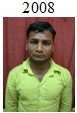

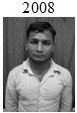

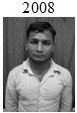

In [10]:

#photoToCompare = '69000/69999.png'
#photoToCompare = 'Sample/SOLA-U-036 Umer Hafiz Abdul Dandoti  F.jpg'
photoToCompare = 'Sample/KAL-A-00131-ACCUSED-MAHESH APPASAHEB VARALE - 2008 .jpg'
#photoToCompare = 'Sample/JUH-SP-267-Ameya Rege-L.jpg'
#display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': photoToCompare})))
urllib.request.urlretrieve(
  s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': photoToCompare}),
   "photoToCompare.jpg")
img = Image.open("photoToCompare.jpg")
display(img)
#display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': photoToCompare})))

s3_connection = boto3.resource('s3')
s3_object = s3_connection.Object(bucketName,photoToCompare)
s3_response = s3_object.get()

stream = io.BytesIO(s3_response['Body'].read())
image=Image.open(stream)
imgGray = image.convert('L')
display(imgGray)

blurImage = imgGray.filter(ImageFilter.GaussianBlur(0))
display(blurImage)

SEARCH FACE AND PLOT IT

{'SearchedFaceBoundingBox': {'Width': 0.3293653130531311, 'Height': 0.28139498829841614, 'Left': 0.3576861321926117, 'Top': 0.2672053575515747}, 'SearchedFaceConfidence': 99.98799896240234, 'FaceMatches': [{'Similarity': 100.0, 'Face': {'FaceId': '262f088e-28b1-4db2-b65a-f9be2002d60f', 'BoundingBox': {'Width': 0.3243429958820343, 'Height': 0.28003600239753723, 'Left': 0.3612639904022217, 'Top': 0.2674520015716553}, 'ImageId': 'a38c9d4a-723e-3ca1-ad4f-e9dc924adf1a', 'ExternalImageId': 'Sample-:-KAL-A-00131-ACCUSED-MAHESH:::APPASAHEB:::VARALE:::-:::2008:::.jpg', 'Confidence': 99.9872055053711}}, {'Similarity': 99.99999237060547, 'Face': {'FaceId': 'e52ca2b5-a7d4-452c-80f6-bd0d5ab16319', 'BoundingBox': {'Width': 0.08344049751758575, 'Height': 0.24525000154972076, 'Left': 0.24262000620365143, 'Top': 0.2588050067424774}, 'ImageId': '0c44cb19-d311-366c-83b7-2289e1270bb9', 'ExternalImageId': 'Sample-:-KAL-A-00131-ACCUSED-MAHESH:::APPASAHEB:::VARALE.jpg', 'Confidence': 99.97660064697266}}, {'S

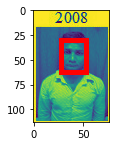

Image id from the database that matched is Sample/KAL-A-00131-ACCUSED-MAHESH APPASAHEB VARALE - 2008 .jpg 
Match similarity is 100.0 


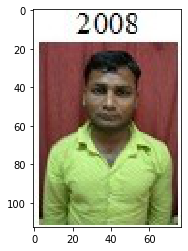

Image id from the database that matched is Sample/KAL-A-00131-ACCUSED-MAHESH APPASAHEB VARALE.jpg 
Match similarity is 99.99999237060547 


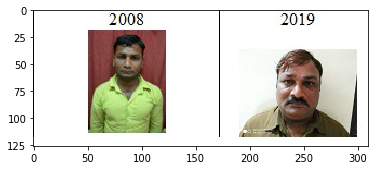

Image id from the database that matched is Sample/KAL-A-00131-ACCUSED-MAHESH APPASAHEB VARALE - 2016.jpg 
Match similarity is 85.61302185058594 


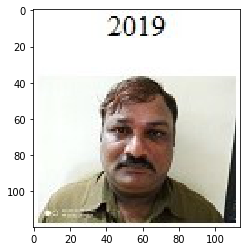

Image id from the database that matched is Sample/KAL-A-00131-ACCUSED-MAHESH APPASAHEB VARALE.jpg 
Match similarity is 85.15055084228516 


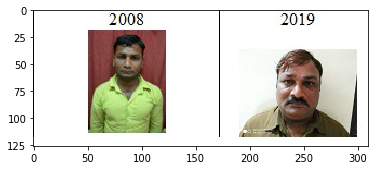

In [14]:
img_byte_arr = io.BytesIO()
blurImage.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()
    
response = rekognition.search_faces_by_image(
    CollectionId=collectionId,
    Image={
        'Bytes':img_byte_arr     
    },
    MaxFaces=123,
    QualityFilter='MEDIUM'
)
print(response)
print("input image is -- ")

imgWidth, imgHeight = blurImage.size  
#draw = ImageDraw.Draw(image) 
#image.show()


# create figure
fig = plt.figure(figsize=(10, 7))

if(response['FaceMatches']):
    print("Input image is")
    fig.add_subplot(3, 3, 5)
    plt.imshow(blurImage)

    # Get the current reference
    ax = plt.gca()

    #print(response['SearchedFaceBoundingBox']['Left'])

    # Create a Rectangle patch
    rect = Rectangle((imgWidth*response['SearchedFaceBoundingBox']['Left'],imgHeight*response['SearchedFaceBoundingBox']['Top']),
                     imgWidth*response['SearchedFaceBoundingBox']['Width'],imgHeight*response['SearchedFaceBoundingBox']['Height'],linewidth=5,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()
    for idx,object in enumerate(response['FaceMatches']):
        externalImageId= response['FaceMatches'][idx]['Face']['ExternalImageId']
        externalImageIdRestoreWhiteSpace=externalImageId.replace(":::"," ")
        externalImageIdRestoreSlash=externalImageIdRestoreWhiteSpace.replace("-:-","/")
        print("Image id from the database that matched is {} ".format(externalImageIdRestoreSlash))
        print("Match similarity is {} ".format(response['FaceMatches'][idx]['Similarity']))
        
        urllib.request.urlretrieve(
          s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': externalImageIdRestoreSlash}),
           "photoToreference.jpg")
        databaseImage = Image.open("photoToreference.jpg")
        #display(databaseImage)


        databaseImageWidth,databaseImageHeight = databaseImage.size

        # Adds a subplot at the 1st position
        fig.add_subplot(3, 3, idx+1)
        plt.imshow(databaseImage)
        plt.show()



INPUT AN MP4. EXTRACT IMAGES FROM FRAME AND COMPARE AGAINST EXISTING DATABASE

Before processing file number 101 --  Sample/Staff photos/WhatsApp Video 2021-12-06 at 10.50.58 AM.mp4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


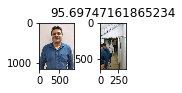

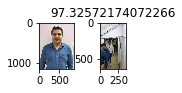

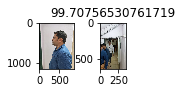

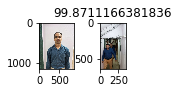

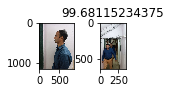

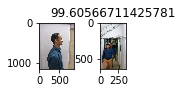

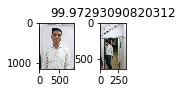

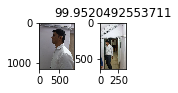

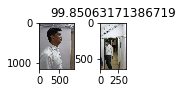

Before processing file number 102 --  Sample/Staff photos/WhatsApp Video 2021-12-06 at 10.52.30 AM.mp4
Before processing file number 103 --  Sample/Staff photos/WhatsApp Video 2021-12-06 at 10.52.47 AM.mp4


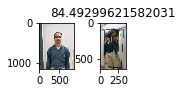

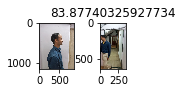

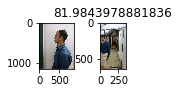

Before processing file number 104 --  Sample/Staff photos/WhatsApp Video 2021-12-06 at 10.55.51 AM.mp4


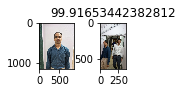

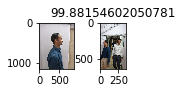

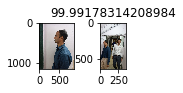

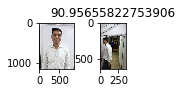

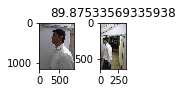

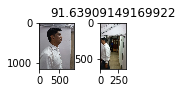

In [15]:
import cv2

  
    
try:

    s3objects= s3.list_objects_v2(Bucket=bucketName)
    for idx, object in enumerate(s3objects['Contents']):

        if(".mp4" not in object['Key']):
            #print(f"skipping file named {object['Key']} from indexing because it is not an mp4 file.")
            continue
        print("Before processing file number {} -- ".format(idx),object['Key'])            
        # Read the video from specified path
        cam = cv2.VideoCapture(s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': object['Key']}))
        imageFrameDict = {}
        # frame
        currentframe = 0

        while(True):

            # reading from frame
            ret,frame = cam.read()

            if ret:
                #imageFrameDict = {}
                # Display the resulting frame 
                fImage = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frameImage = Image.fromarray(fImage)
                #plt.imshow(frameImage)
                #plt.title('Frames')
                #plt.show()
                currentframe+=1
                # Press Q on keyboard to stop
                #if cv2.waitKey(1) & currentframe==50:
                #      break
                frameimg_byte_arr = io.BytesIO()
                frameImage.save(frameimg_byte_arr, format='PNG')
                frameimg_byte_arr = frameimg_byte_arr.getvalue()
                #frameimg_byte_arr = frameImage.getvalue()
                try:
                    response = rekognition.search_faces_by_image(
                        CollectionId=collectionId,
                        Image={
                            'Bytes':frameimg_byte_arr     
                        },
                        MaxFaces=123,
                        QualityFilter='MEDIUM'
                    )
                except Exception as e:
                    continue
                # create figure
                #videoFig = plt.figure(figsize=(10, 7))
                if(response['FaceMatches']):
                    #print(response)
                    #plt.imshow(frameImage)                    
                    for idx,object in enumerate(response['FaceMatches']):
                        externalImageId= response['FaceMatches'][idx]['Face']['ExternalImageId']
                        externalImageIdRestoreWhiteSpace=externalImageId.replace(":::"," ")
                        externalImageIdRestoreSlash=externalImageIdRestoreWhiteSpace.replace("-:-","/")
                        #print("Image id from the database that matched is {} ".format(externalImageIdRestoreSlash))
                        #print("Match similarity is {} ".format(response['FaceMatches'][idx]['Similarity']))
                        imageFrameDict.setdefault(externalImageIdRestoreSlash,[]).append({response['FaceMatches'][idx]['Similarity']:frameImage})                       
                        #imageFrameDict[externalImageIdRestoreSlash].append(frameImage)
                    
                    
             
            else:
                break

        # Release all space and windows once done
        cam.release()
        
        # Display Database Image and Frame images
        # iterate over dictionary
        for databaseImagePath,frameValues in imageFrameDict.items():
            videoFig = plt.figure(figsize=(15, 15))
            urllib.request.urlretrieve(
              s3.generate_presigned_url('get_object', Params={'Bucket': bucketName, 'Key': databaseImagePath}),
               "photoToreference.jpg")
            databaseImage = Image.open("photoToreference.jpg")
            databaseImageSubPLot=videoFig.add_subplot(15, 15, idx+1)
            databaseImageSubPLot.imshow(databaseImage)
            #display(frameImage)                        
            for frameValue in frameValues:
                for frameValueSimilarity,frameValueImage in frameValue.items():
            # Adds a subplot at the 1st position
                    frameImageubPlot=videoFig.add_subplot(15, 15, idx+2)
                    plt.title(frameValueSimilarity)
                    frameImageubPlot.imshow(frameValueImage)

            plt.show()

except Exception as e:
    #print("Error processing object {} from bucket {}. ".format(object['Key'], bucketName))
    raise e

In [ ]:
#!apt-get install ffmpeg libsm6 libxext6  -y
!apt-get update
!apt-get install -y python3-opencv
!pip install opencv-python